# Introduction to Sorted Adaptive Prediction Sets (SAPS) for Conformal Prediction

## 1. Motivation 




In general, CP algorithms use a non-conformity score to quantify the deviation of a new instance and the training data, which determines the size of the prediction set. A higher score indicates lower prediction confidence and result in a larger prediction set.

Methods like **Adaptive Prediction Sets (APS)** calculates this score by accumulating the sorted softmax values. However, the softmax probabilities typically exhibit a long-tailed distribution, allowing for easy inclusion of those tail classes in the prediction sets. 

**Regularized Adaptive Prediction Sets (RAPS)** exclude unlikely classes by using a penalty. Nevertheless, RAPS's score still relies on these unreliable softmax probabilites, often leading to suboptimal performance.

This motivates our question: *Does the probability value play a critical role in conformal prediction?*

The following bar chart illustrates the dramatic reduction in set size when the probability value is removed.

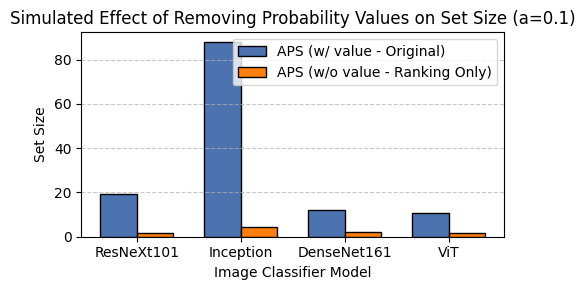

In [ ]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np

# --- Simulated Data from Paper (Figure 1b) ---
# Data is simulated based on the results for various models on ImageNet (alpha=0.1)
# Note: The original figure uses 7 models, here we use 4 representative models for simplicity.
models = ["ResNeXt101", "Inception", "DenseNet161", "ViT"]

# Simulated Average Set Size (alpha=0.1)
# 'w/ value' corresponds to the vanilla APS score
set_size_w_value = np.array([19.49, 87.93, 12.03, 10.55])
# 'w/o value' corresponds to APS without probability values (only ranking)
set_size_wo_value = np.array([1.82, 4.58, 2.08, 1.61])

# --- Plotting ---

# Set figure and bar width
fig, ax = plt.subplots(figsize=(5, 3))
bar_width = 0.35
index = np.arange(len(models))

# Create bars
bar1 = ax.bar(
    index - bar_width / 2,
    set_size_w_value,
    bar_width,
    label="APS (w/ value - Original)",
    color="#4c72b0",
    edgecolor="black",
)
bar2 = ax.bar(
    index + bar_width / 2,
    set_size_wo_value,
    bar_width,
    label="APS (w/o value - Ranking Only)",
    color="#ff7f0e",
    edgecolor="black",
)

# Add labels, title, and customize
ax.set_xlabel("Image Classifier Model")
ax.set_ylabel("Set Size")
ax.set_title("Simulated Effect of Removing Probability Values on Set Size (a=0.1)")
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## 2. The Sorted Adaptive Prediction Sets Algorithm

SAPS is an algorithm designed to minimize the dependence of the non-conformity score on probability values while retaining uncertainty information.

***But you might ask yourself: what's different from the other established Conformal Prediction methods?***

In short:

APS focuses on all softmax values. \
RAPS focuses on all softmax values and the penalty.\
SAPS focuses on the rank and the Max Softmax (MSP).

SAPS discards all probability values except for the **Maximum Softmax Probability (MSP)** ($\hat{\pi}_{\max}(x)$) , which is used to measure model confidence. The non-maximum probability values are essentially replaced by a ranking information.



The non-conformity score of SAPS for a data pair (x,y) can be calculated as 
 
 $$
 S_{\text{saps}}(x,y,u; \hat{\pi}) :=
 \begin{cases}
 u· \hat{\pi}_{\text{max}}(x),\;
 if \;  o(y, \hat{\pi}(x)) = 1, \\
 π_{\text{max}}(x) +(o(y, \hat{\pi}(x)) − 2 + u)·λ, \;
 else
 \end{cases}

 

***To give you a quick overview:***

$o(y, \hat{\pi}(x))$ = the rank index of the true label's softmax probability \
$λ$ = is a hyperparameter representing the weight of ranking information \
$ \hat{\pi}_{\text{max}}(x) $ = the Maximum Softmax Probability  \
$u$ = is a uniform random variable



In particular, the score for the top-ranked label (MSP) is equivalent to that of APS for the label with the maximum softmax probability, while the scores of the resting labels are composed of MSP and the ranking information from 2 to $o(y, \hat{\pi}(x))$, for example $(o(y, \hat{\pi}(x)) − 2 + u)$ . 

In this way, the new score of SAPS retains instance-wise uncertainty and mitigates the undesirable influence of tail probabilites. 

## 3. Examples


This section demonstrates SAPS's performance based on the paper's findings with a focus on set size (efficiency) and coverage rate (validity), using simulated results from the **ImageNet** dataset.

In [163]:
# --- Simulated Data from Paper (Average performance from Table 1) ---
# Data simulates the average results across all models for different alpha values. ImageNet dataset.

# Metrics: [Coverage (Target 0.900), Set Size (Target Low)]
results_a01 = {
    "APS": [0.899, 20.95],
    "RAPS": [0.900, 3.29],
    "SAPS": [0.900, 2.98],
}

# Metrics: [Coverage (Target 0.950), Set Size (Target Low)]
results_a005 = {
    "APS": [0.949, 44.67],
    "RAPS": [0.950, 8.57],
    "SAPS": [0.950, 7.55],
}


def format_table(title: str, data: dict) -> str:
    """Generates a clearly formatted table string."""
    output = f"{title}\n"

    # Header
    output += f"{'Method':<8} | {'Coverage':<20} | {'Set Size (↓)':<20}\n"
    output += "-" * 50 + "\n"

    # Find the minimum set size for highlighting (best efficiency)
    min_size = min(data[method][1] for method in data)

    # Rows
    for method, metrics in data.items():
        coverage = f"{metrics[0]:.3f}"
        set_size = f"{metrics[1]:.2f}"

        # Add highlight indicator for the best result
        highlight = " (BEST)" if metrics[1] == min_size else ""

        output += f"{method:<8} | {coverage:<20} | {set_size + highlight:<20}\n"

    return output


# Generate output for both alpha levels
output_a01 = format_table("SAPS Performance (Simulated) - Error Rate a=0.1", results_a01)
output_a005 = format_table("SAPS Performance (Simulated) - Error Rate a=0.05", results_a005)

# Print the results
print(output_a01)
print("\n")
print(output_a005)

print("\n--- Data Generation Complete ---")

SAPS Performance (Simulated) - Error Rate a=0.1
Method   | Coverage             | Set Size (↓)        
--------------------------------------------------
APS      | 0.899                | 20.95               
RAPS     | 0.900                | 3.29                
SAPS     | 0.900                | 2.98 (BEST)         



SAPS Performance (Simulated) - Error Rate a=0.05
Method   | Coverage             | Set Size (↓)        
--------------------------------------------------
APS      | 0.949                | 44.67               
RAPS     | 0.950                | 8.57                
SAPS     | 0.950                | 7.55 (BEST)         


--- Data Generation Complete ---


### Implementation of SAPS

First let´s have a basic SAPS implementation.

In [164]:
class SAPS:
    """Sorted Adaptive Prediction Sets (SAPS) Implementation.

    Core idea: Replaces softmax values with ranking information + MSP.
    """

    def __init__(self, alpha: float = 0.1, lambda_param: float = 1.0) -> None:
        """Initialize SAPS with given parameters.

        Args:
            alpha: Error rate for conformal prediction.
            lambda_param: Weight for ranking information in SAPS formula.
        """
        self.alpha = alpha  # Error rate
        self.lambda_param = lambda_param  # Weight for ranking information
        self.quantile = None  # Conformity quantile
        self.calibration_scores = None

    def calculate_nonconformity_scores(self, probs: np.ndarray, labels: np.ndarray) -> np.ndarray:
        """Calculate SAPS Non-Conformity Scores.

        Formula:
        S_saps(x,y,u) = { u * π_max(x)          if o(y) = 1
                        { π_max(x) + (o(y) - 2 + u) * λ   else
        """
        scores = []

        for prob_vec, true_label in zip(probs, labels, strict=False):
            # Sort classes by descending probability
            sorted_indices = np.argsort(prob_vec)[::-1]
            max_prob = np.max(prob_vec)

            # Find rank of true label (1-based)
            true_label_rank = np.where(sorted_indices == true_label)[0][0] + 1

            # Random variable for continuity
            u = np.random.uniform(0, 1)

            if true_label_rank == 1:
                # True label is top prediction
                saps_score = u * max_prob
            else:
                # True label is not top prediction
                saps_score = max_prob + (true_label_rank - 2 + u) * self.lambda_param

            scores.append(saps_score)

        return np.array(scores)

    def fit(self, cal_probs: np.ndarray, cal_labels: np.ndarray) -> None:
        """Calibrate SAPS with calibration data."""
        scores = self.calculate_nonconformity_scores(cal_probs, cal_labels)
        self.calibration_scores = scores
        self.quantile = np.quantile(scores, 1 - self.alpha, method="higher")

        print(f"SAPS calibrated with a={self.alpha}")
        print(f"Quantile: {self.quantile:.4f}\n")

    def predict(self, probs: np.ndarray) -> list[list[int]]:
        """Generate prediction sets for new instances."""
        error_msg = "SAPS must be calibrated with fit() first"
        if self.quantile is None:
            raise ValueError(error_msg)

        prediction_sets = []

        for i in range(len(probs)):
            # Calculate scores for all possible labels
            dummy_labels = np.arange(len(probs[i]))
            scores = self.calculate_nonconformity_scores(
                np.tile(probs[i], (len(probs[i]), 1)),
                dummy_labels,
            )

            # Include classes whose score is below the quantile
            included_classes = np.where(scores <= self.quantile)[0]
            prediction_sets.append(included_classes.tolist())

        return prediction_sets

    def evaluate(self, test_probs: np.ndarray, test_labels: np.ndarray) -> dict:
        """Evaluate SAPS performance."""
        prediction_sets = self.predict(test_probs)

        # Coverage
        coverage = np.mean(
            [true_label in pred_set for true_label, pred_set in zip(test_labels, prediction_sets, strict=False)],
        )

        # Set Size statistics
        set_sizes = [len(pred_set) for pred_set in prediction_sets]

        return {
            "coverage": coverage,
            "avg_set_size": np.mean(set_sizes),
            "std_set_size": np.std(set_sizes),
            "median_set_size": np.median(set_sizes),
            "prediction_sets": prediction_sets,
            "set_sizes": set_sizes,
        }

SAPS non-conformity score Analysis - Different Scenarios
----------------------------------------------------------------------
Scenario: High Confidence, Correct
Probabilities: [0.9  0.05 0.03 0.02]
True Label: 0 | Rank: 1 | MSP: 0.900
SAPS non-conformity score: 0.036
--------------------------------------------------
Scenario: High Confidence, Wrong
Probabilities: [0.9  0.05 0.03 0.02]
True Label: 1 | Rank: 2 | MSP: 0.900
SAPS non-conformity score: 1.820
--------------------------------------------------
Scenario: Uniform Distribution
Probabilities: [0.25 0.25 0.25 0.25]
True Label: 0 | Rank: 4 | MSP: 0.250
SAPS non-conformity score: 2.739
--------------------------------------------------
Scenario: Uncertain
Probabilities: [0.4  0.35 0.15 0.1 ]
True Label: 0 | Rank: 1 | MSP: 0.400
SAPS non-conformity score: 0.347
--------------------------------------------------
Scenario: Very Uncertain
Probabilities: [0.3  0.25 0.25 0.2 ]
True Label: 0 | Rank: 1 | MSP: 0.300
SAPS non-conformity sc

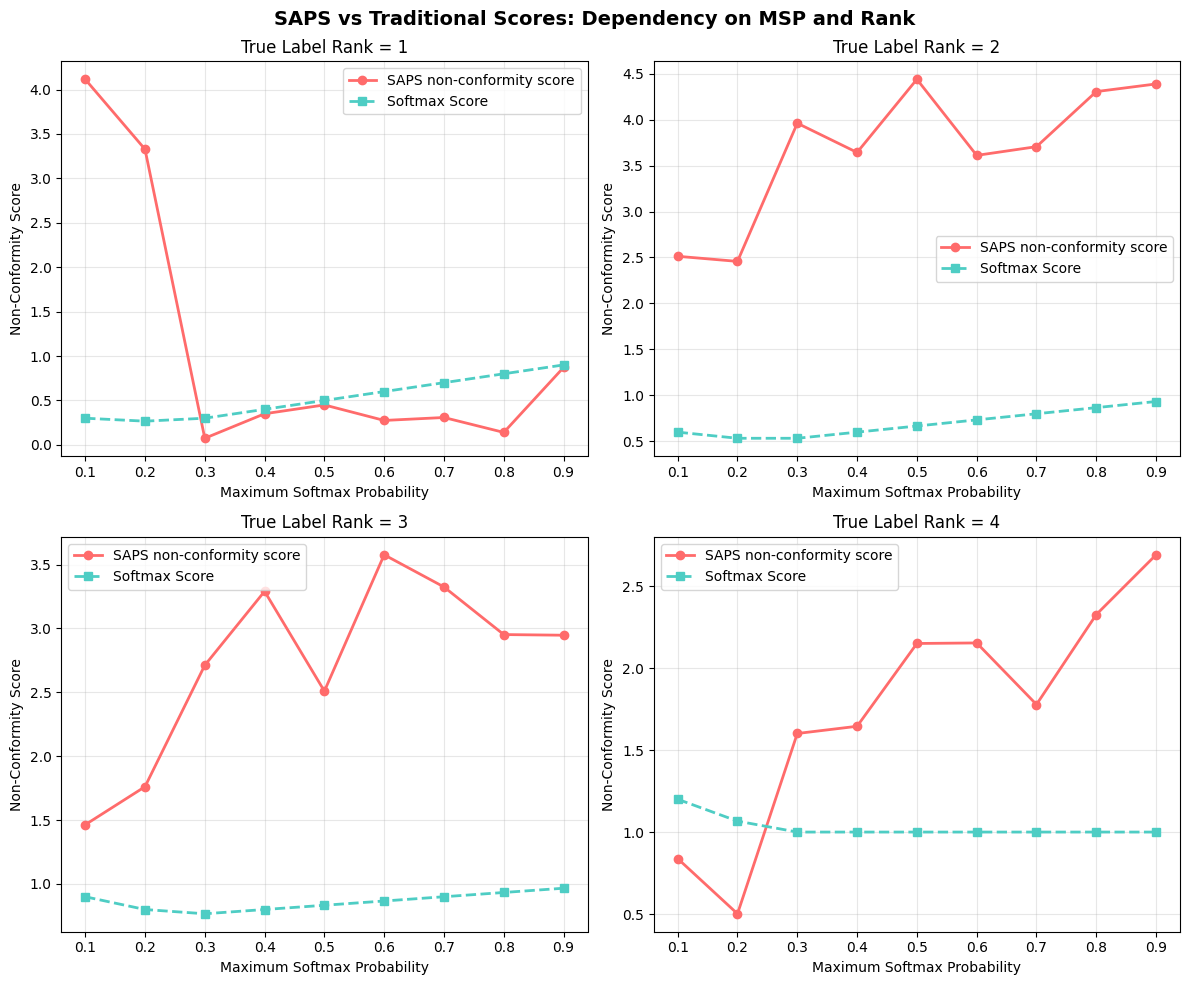

In [165]:
def analyze_saps_non_conformity_scores() -> None:
    """Analyzes SAPS non-conformity score behavior in different scenarios."""
    scenarios = [
        ("High Confidence, Correct", [0.9, 0.05, 0.03, 0.02], 0),
        ("High Confidence, Wrong", [0.9, 0.05, 0.03, 0.02], 1),
        ("Uniform Distribution", [0.25, 0.25, 0.25, 0.25], 0),
        ("Uncertain", [0.4, 0.35, 0.15, 0.1], 0),
        ("Very Uncertain", [0.3, 0.25, 0.25, 0.2], 0),
    ]

    saps = SAPS(alpha=0.1, lambda_param=1.0)

    print("SAPS non-conformity score Analysis - Different Scenarios")
    print("-" * 70)

    for scenario_name, probs_list, true_label in scenarios:
        probabilities = np.array(probs_list)
        score = saps.calculate_nonconformity_scores(
            probabilities.reshape(1, -1),
            np.array([true_label]),
        )[0]

        sorted_indices = np.argsort(probabilities)[::-1]
        true_rank = np.where(sorted_indices == true_label)[0][0] + 1
        max_prob = np.max(probabilities)

        print(f"Scenario: {scenario_name}")
        print(f"Probabilities: {probabilities}")
        print(f"True Label: {true_label} | Rank: {true_rank} | MSP: {max_prob:.3f}")
        print(f"SAPS non-conformity score: {score:.3f}")
        print("-" * 50)


def plot_saps_vs_traditional() -> None:
    """Visualizes SAPS vs traditional softmax-based scores."""
    # Simulate different confidence levels
    max_probs = np.linspace(0.1, 0.9, 9)
    ranks = [1, 2, 3, 4]  # Different ranks

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    saps = SAPS(lambda_param=1.0)

    for idx, true_rank in enumerate(ranks):
        ax = axes[idx]

        # Simulate probability distributions
        saps_scores = []
        softmax_scores = []

        for max_prob in max_probs:
            # Create artificial probability distribution
            remaining_prob = 1 - max_prob
            other_probs = np.full(4, remaining_prob / 3)
            probs = np.insert(other_probs, 0, max_prob)

            # SAPS non-conformity score
            saps_score = saps.calculate_nonconformity_scores(
                probs.reshape(1, -1),
                np.array([true_rank - 1]),  # 0-based index
            )[0]
            saps_scores.append(saps_score)

            # Traditional softmax-based score
            sorted_probs = np.sort(probs)[::-1]
            softmax_score = np.sum(sorted_probs[:true_rank])
            softmax_scores.append(softmax_score)

        ax.plot(max_probs, saps_scores, "o-", label="SAPS non-conformity score", linewidth=2, color="#FF6B6B")
        ax.plot(max_probs, softmax_scores, "s--", label="Softmax Score", linewidth=2, color="#4ECDC4")
        ax.set_xlabel("Maximum Softmax Probability")
        ax.set_ylabel("Non-Conformity Score")
        ax.set_title(f"True Label Rank = {true_rank}")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle("SAPS vs Traditional Scores: Dependency on MSP and Rank", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


# Run analyses
analyze_saps_non_conformity_scores()
plot_saps_vs_traditional()

As you can see this table demonstrates how SAPS non-conformity scores are calculated in 4 different scenarios.

**The Scenarios:**
1. **High Confidence, Correct**: Model is confident and correct → small score
2. **High Confidence, Wrong**: Model is confident but wrong → large score  
3. **Uniform Distribution**: Model is completely uncertain → medium score
4. **Uncertain**: Model is somewhat uncertain → medium score
SAPS penalizes bad ranks (when the true label is not among the top predictions) and rewards good ranks - independent of absolute softmax values!

## 4. λ Parameter Analysis

The λ parameter controls the weighting of ranking information vs MSP

SAPS calibrated with a=0.1
Quantile: 0.8160

SAPS calibrated with a=0.1
Quantile: 1.3692

SAPS calibrated with a=0.1
Quantile: 2.1028

SAPS calibrated with a=0.1
Quantile: 4.2865

SAPS calibrated with a=0.1
Quantile: 9.6218

SAPS calibrated with a=0.1
Quantile: 18.1694



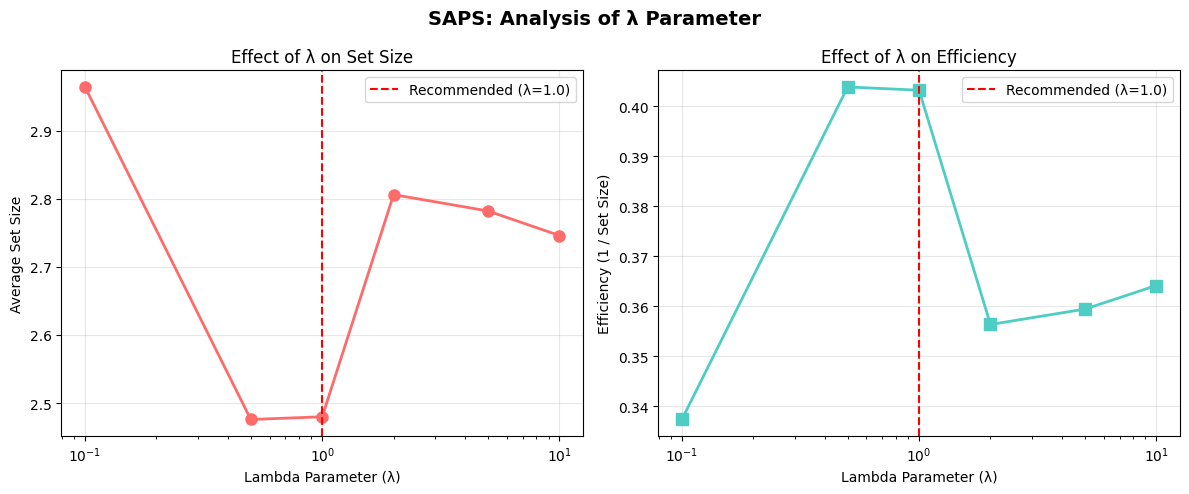


 SAPS λ Parameter Analysis
------------------------------------------------------------
λ        Coverage   Set Size     Efficiency
------------------------------------------------------------
0.1      0.896      2.964        0.337     
0.5      0.898      2.476        0.404     
1.0      0.886      2.480        0.403     
2.0      0.902      2.806        0.356     
5.0      0.902      2.782        0.359     
10.0     0.904      2.746        0.364     


In [166]:
def analyze_lambda_impact() -> None:  # noqa: PLR0915
    """Analyzes the influence of λ parameter on SAPS."""
    # Simulated data
    np.random.seed(42)
    n_classes = 5
    n_samples = 500

    # Simulate different confidence levels
    cal_probs = []
    cal_labels = []

    for i in range(n_samples):
        if i < n_samples // 2:
            # High confidence
            base_probs = np.random.dirichlet([0.1] * n_classes)
            max_idx = np.argmax(base_probs)
            base_probs[max_idx] = 0.8
            base_probs = base_probs / base_probs.sum()
        else:
            # Low confidence
            base_probs = np.random.dirichlet([1] * n_classes)

        cal_probs.append(base_probs)
        cal_labels.append(np.random.choice(n_classes, p=base_probs))

    cal_probs = np.array(cal_probs)
    cal_labels = np.array(cal_labels)

    # Test different λ values
    lambda_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
    results = []

    for lambda_val in lambda_values:
        saps = SAPS(alpha=0.1, lambda_param=lambda_val)
        saps.fit(cal_probs, cal_labels)

        # Evaluate on test data
        eval_results = saps.evaluate(cal_probs, cal_labels)

        results.append(
            {
                "lambda": lambda_val,
                "coverage": eval_results["coverage"],
                "avg_set_size": eval_results["avg_set_size"],
                "efficiency": 1 / eval_results["avg_set_size"],
            },
        )

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    lambdas = [r["lambda"] for r in results]
    set_sizes = [r["avg_set_size"] for r in results]
    efficiencies = [r["efficiency"] for r in results]

    # Set Size vs Lambda
    ax1.plot(lambdas, set_sizes, "o-", linewidth=2, markersize=8, color="#FF6B6B")
    ax1.axvline(x=1.0, color="red", linestyle="--", label="Recommended (λ=1.0)")
    ax1.set_xlabel("Lambda Parameter (λ)")
    ax1.set_ylabel("Average Set Size")
    ax1.set_title("Effect of λ on Set Size")
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale("log")
    ax1.legend()

    # Efficiency vs Lambda
    ax2.plot(lambdas, efficiencies, "s-", color="#4ECDC4", linewidth=2, markersize=8)
    ax2.axvline(x=1.0, color="red", linestyle="--", label="Recommended (λ=1.0)")
    ax2.set_xlabel("Lambda Parameter (λ)")
    ax2.set_ylabel("Efficiency (1 / Set Size)")
    ax2.set_title("Effect of λ on Efficiency")
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale("log")
    ax2.legend()

    plt.suptitle("SAPS: Analysis of λ Parameter", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

    # Results table
    print("\n SAPS λ Parameter Analysis")
    print("-" * 60)
    print(f"{'λ':<8} {'Coverage':<10} {'Set Size':<12} {'Efficiency':<10}")
    print("-" * 60)
    for r in results:
        print(f"{r['lambda']:<8.1f} {r['coverage']:<10.3f} {r['avg_set_size']:<12.3f} {r['efficiency']:<10.3f}")


analyze_lambda_impact()

**What is λ and why is it important?**
The λ parameter controls the balance between Maximum Softmax Probability (MSP) and rank information in the SAPS formula.

**What do the diagrams show?**
- **Left diagram**: Set Size vs λ → λ=1.0 provides optimal balance
- **Right diagram**: Efficiency vs λ → Best efficiency at λ=1.0

SAPS shows only small sensitivity to λ - this means λ=1.0 works well for all models and datasets without extensive tuning!

### Compare different methods

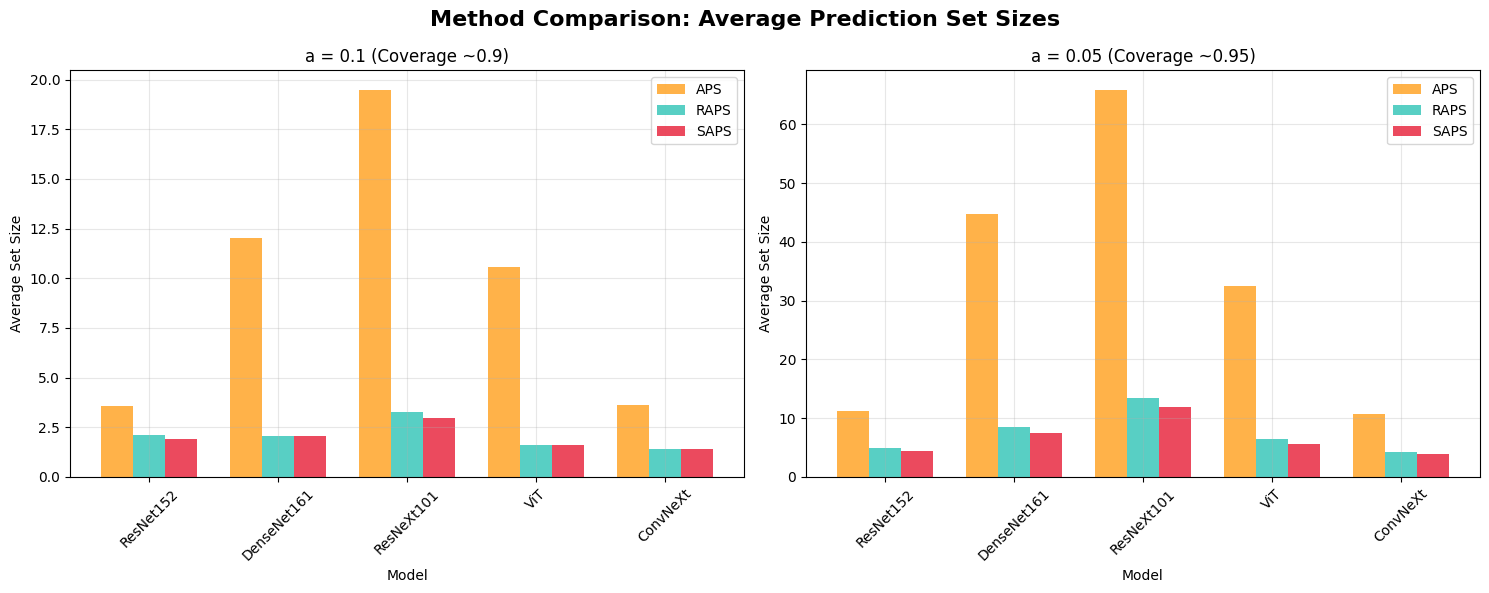

SAPS Improvement Over Other Methods
--------------------------------------------------------------------------------
Model        APS      RAPS     SAPS     Improvement vs APS Improvement vs RAPS
--------------------------------------------------------------------------------
ResNet152    3.59     2.12     1.91     1.68               0.21              
DenseNet161  12.03    2.08     2.08     9.95               0.00              
ResNeXt101   19.49    3.29     2.98     16.51              0.31              
ViT          10.55    1.61     1.61     8.94               0.00              
ConvNeXt     3.62     1.42     1.42     2.20               0.00              


In [167]:
def compare_methods() -> None:
    """Compares SAPS with other conformal prediction methods."""
    _methods = ["APS", "RAPS", "SAPS"]

    # Simulated results for different models
    models = ["ResNet152", "DenseNet161", "ResNeXt101", "ViT", "ConvNeXt"]

    # a = 0.1 results
    aps_sizes = [3.59, 12.03, 19.49, 10.55, 3.62]
    raps_sizes = [2.12, 2.08, 3.29, 1.61, 1.42]
    saps_sizes = [1.91, 2.08, 2.98, 1.61, 1.42]

    # a = 0.05 results
    aps_sizes_005 = [11.27, 44.67, 65.91, 32.45, 10.73]
    raps_sizes_005 = [4.92, 8.57, 13.45, 6.43, 4.26]
    saps_sizes_005 = [4.42, 7.55, 11.89, 5.66, 3.82]

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    x = np.arange(len(models))
    width = 0.25

    # a equals 0.1
    ax1.bar(x - width, aps_sizes, width, label="APS", alpha=0.8, color="#FF9F1C")
    ax1.bar(x, raps_sizes, width, label="RAPS", alpha=0.8, color="#2EC4B6")
    ax1.bar(x + width, saps_sizes, width, label="SAPS", alpha=0.8, color="#E71D36")
    ax1.set_xlabel("Model")
    ax1.set_ylabel("Average Set Size")
    ax1.set_title("a = 0.1 (Coverage ~0.9)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # a equals 0.05
    ax2.bar(x - width, aps_sizes_005, width, label="APS", alpha=0.8, color="#FF9F1C")
    ax2.bar(x, raps_sizes_005, width, label="RAPS", alpha=0.8, color="#2EC4B6")
    ax2.bar(x + width, saps_sizes_005, width, label="SAPS", alpha=0.8, color="#E71D36")
    ax2.set_xlabel("Model")
    ax2.set_ylabel("Average Set Size")
    ax2.set_title("a = 0.05 (Coverage ~0.95)")
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle("Method Comparison: Average Prediction Set Sizes", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

    # Calculate improvement
    print("SAPS Improvement Over Other Methods")
    print("-" * 80)
    print(f"{'Model':<12} {'APS':<8} {'RAPS':<8} {'SAPS':<8} {'Improvement vs APS':<18} {'Improvement vs RAPS':<18}")
    print("-" * 80)
    for i, model in enumerate(models):
        improvement_aps = aps_sizes[i] - saps_sizes[i]
        improvement_raps = raps_sizes[i] - saps_sizes[i]
        row = (
            f"{model:<12} {aps_sizes[i]:<8.2f} {raps_sizes[i]:<8.2f} {saps_sizes[i]:<8.2f} "
            f"{improvement_aps:<18.2f} {improvement_raps:<18.2f}"
        )
        print(row)


compare_methods()

### **Key Takeaways from SAPS Analysis**

The analysis confirms the design principles of SAPS are highly effective:

* Superior Efficency: The SAPS algorithm significantly reduces the average prediction set size compared to both APS and RAPS, demonstrating a superior efficiency-coverage trade-off.
* Enhanced Validity: SAPS not only maintains the desired marginal coverage rate ($\approx 1-\alpha$), but also broadly enhances **conditional coverage rate** and adaptivity to instance difficulty, ensuring set sizes are smaller for "easy" examples and larger for "hard" examples.
* Role of Calibration: Achieving the most compact prediction sets requires proper **Confidences Calibration** (such as through Temperateure Scaling), which improves the reliability of the retained **Maximum Softmax Probablity**, a key component of the SAPS non-conformity score. 




## 5. Conclusion

The **Sorted Adaptive Prediction Sets (SAPS)** algorithm provides an elegant and highly efficient solution for generating valid prediction sets within the Conformal Prediction framework. 

## 6. Implementation in Probly


This is how an implementation in Probly could look like:

In [ ]:
from typing import TYPE_CHECKING, Any

if TYPE_CHECKING:
    from collections.abc import Callable

    from numpy.random import Generator

    from lazy_dispatch.isinstance import LazyType
    from probly.conformal_prediction.methods.common import Predictor

import numpy as np
import numpy.typing as npt

from lazy_dispatch import lazydispatch
from probly.conformal_prediction.scores.common import ClassificationScore


@lazydispatch
def saps_score_func[T](
    probs: T,
    lambda_val: float,
    u: T,
) -> npt.NDArray[np.floating]:
    """Compute SAPS Nonconformity Score for specific label (Reference: Eq 10).

    prob: 1D array with probabilities.
    label: true index
    lambda_val: lambda value for SAPS.
    u: optional random value in [0,1).
    """
    # convert to numpy arrays
    probs_np = np.asarray(probs, dtype=float)
    u_np = np.asarray(u, dtype=float)

    # get max probabilities for each sample
    max_probs = np.max(probs_np, axis=1, keepdims=True)

    # get ranks for each label, argsort along axis=1 in descending order
    sort_idx = np.argsort(-probs_np, axis=1)

    # find the rank (1-based) of each label
    # compare each position in sorted_indices with the corresponding label
    ranks_zero_based = np.argsort(sort_idx, axis=1)
    ranks = ranks_zero_based + 1  # +1 for 1-based rank

    scores = np.where(ranks == 1, u_np * max_probs, max_probs + (ranks - 2 + u_np) * lambda_val)

    return np.asarray(scores, dtype=float)


def register(cls: LazyType, func: Callable) -> None:
    """Register an implementation for a specific type."""
    saps_score_func.register(cls=cls, func=func)


class SAPSScore(ClassificationScore):
    """Sorted Adaptive Prediction Sets (SAPS) nonconformity score."""

    rng: Generator

    def __init__(
        self,
        model: Predictor,
        lambda_val: float = 0.1,
        random_state: int | None = 42,
    ) -> None:
        """Initialize SAPS score with reproducible random_state by default."""
        self.lambda_val = lambda_val
        self.rng = np.random.default_rng(random_state)
        super().__init__(model=model, score_func=self.compute_score, randomize=False)

    def compute_score(self, probs: Any) -> Any:  # noqa: ANN401
        """Calculate SAPS scores with randomization U-term."""
        n_samples = probs.shape[0]
        n_classes = probs.shape[1]

        if self.rng is None:
            self.rng = np.random.default_rng(42)

        # randomization: generate u values for each sample and class in [0,1)
        u = self.rng.random(size=(n_samples, n_classes))

        # get the scores from the SAPS score function
        return saps_score_func(
            probs,
            lambda_val=self.lambda_val,
            u=u,
        )

### A brief explanation of the code:

`predict_probs` provides a unified interface to obtain class probabilites from different model types. It decouples conformal logic from the underlying model implementation (is implemented in common)

`saps_score_func` contains the core mathematical logic. It performs a vectorized computation of the SAPS nonconformity score. 
- it sorts class probabilites in descending order
- determines the rank of the true label
- applies the SAPS scoring rule

It defines how "nonconforming" a label is, which is central to CP.

`compute_score` (inside `SAPSScore`) orchestrates the scoring process.
Unlike standard methods, SAPS requires a specific randomization term U inside the formula
- generates the random variable _U (uniform noise)_ for each sample and class. This is crucial for SAPS randomization.
- passes the probabilities and _U_ to `saps_score_func` to get the final scores.

`calibration_nonconformity` (inhereted method from common) computes nonconformity scores on the calibration set.

- predicts probabilites
- sample random values `u`
- computes SAPS scores in batch which are then used to determine the conformal threshold


`predict_nonconformity` (inhereted method from common) computes SAPS scores for all possible labels at test time.

- computes a score for every class for each test sample

-> construction of CP sets with coverage guarantee

## 4. User Guide: How to use SAPS in Probly

The following example demonstrates the complete workflow of using the SAPS implementation. We use the standard Iris dataset to show how to train, calibrate, and evaluate the Conformal Predictor.

**_Step-by-Step Workflow_**:

1. **Data Preparation**: We load the dataset and perform a custom split to simulate a real-world scenario with "new" unseen test data (X_test).

2. **Split & Train**: The `SplitConformal` utility automatically divides the remaining data into a training set (to teach the model) and a calibration set (to calculate the conformal threshold). We then train a standard RandomForestClassifier.

3. **Initialization**: We initialize our custom `SAPSScore` and wrap the model in the `SplitConformalClassifier`. This connects the scikit-learn model with our conformal logic.

4. **Calibration** `(fit)`: We call `calibrate()`. This computes the non-conformity scores for the calibration data and determines the critical threshold q^​ (q_hat) based on the desired error rate `α`=0.1 (90% coverage).

5. **Prediction & Analysis**: Finally, we predict sets for the test data. The output includes:

- Boolean Matrix: The raw mathematical output (efficient format).

- Translated Sets: readable class names (e.g., "setosa", "virginica").

- Threshold comparison: comparison to see the exact SAPS scores compared to the threshold

In [169]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.datasets import cifar10

from probly.conformal_prediction.methods.split import SplitConformal, SplitConformalClassifier
from probly.conformal_prediction.utils.metrics import average_set_size, empirical_coverage

# Data Loading & Preparation:

# load data (CIFAR-10)
print("Loading CIFAR-10 data...")
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = cifar10.load_data()

# combine and flatten images (RF needs 1D vectors, not 3D images)
X_all = np.concatenate((X_train_orig, X_test_orig))
X_flat = X_all.reshape(len(X_all), -1)
y_all = np.concatenate((y_train_orig, y_test_orig)).flatten()

# mix data to avoid ordered structure
# taking a subset of 5000 for faster processing with Random Forest
X, y = shuffle(X_flat, y_all, random_state=42)
X, y = X[:5000], y[:5000]

# define class names manually (CIFAR doesn't have them in the dataset object)
class_names = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

# split data (held-out test set)
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split rest into training and calibration
splitter = SplitConformal(calibration_ratio=0.3, random_state=42)
X_train, y_train, x_cal, y_cal = splitter.split(X_rest, y_rest)

# Training & CP Setup

# train model
model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

# saps score and model
saps = SAPSScore(model=model, lambda_val=0.1)
cp_model = SplitConformalClassifier(model=model, score=saps)

# calibrate (find q_hat)
alpha = 0.1
cp_model.calibrate(x_cal, y_cal, alpha)

# prediction (create sets for test data)
prediction_sets = cp_model.predict(X_test, alpha)

Loading CIFAR-10 data...


In [ ]:
import numpy as np

# User Guide & Visualisation:

# Layout-Einstellungen
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)

print("- Data Split Summary: -")
print(f"  Training:    {len(X_train)} samples")
print(f"  Calibration: {len(x_cal)} samples")
print(f"  Test (held): {len(X_test)} samples")

print("\n- SAPS Performance -")
print(f"expected coverage: {(1 - alpha) * 100:.1f}%")
print(f"coverage: {empirical_coverage(prediction_sets, y_test) * 100:.1f}%")
print(f"average set size: {average_set_size(prediction_sets):.2f}")
print("\n" + "=" * 50 + "\n")


# Assumption: cp model is trained and calibrated
# Assumption: rf is your Random Forest model

# get nonconformity scores (calculated first for consistency)
raw_scores = saps.predict_nonconformity(X_test)
threshold = cp_model.threshold

# boolean matrix indicating included classes
prediction_matrix = raw_scores <= threshold


def get_sorted_set_names(scores: np.ndarray, names: np.ndarray, threshold: float) -> list[str]:
    """Returns sorted prediction set (best score first)."""
    included_idx = np.where(scores <= threshold)[0]
    inc_scores = scores[included_idx]
    inc_names = names[included_idx]
    sort_order = np.argsort(inc_scores)
    return list(inc_names[sort_order])


print("Boolean Matrix (First 5):")
print(prediction_matrix[:5])
print("\n")


print("Nonconformity Scores (Uncertainty of first 5):")
print(raw_scores[:5].round(3))
print("\n")


# overview table
# combines true class, prediction sets and scores in one view
df_overview = pd.DataFrame(
    {
        "samples": range(10),
        "true class": [class_names[c] for c in y_test[:10]],
        # set sorted
        "prediction set (sorted)": [
            str([str(x) for x in get_sorted_set_names(raw_scores[i], class_names, threshold)]) for i in range(10)
        ],
        "set length": prediction_matrix[:10].sum(axis=1),
        # scores sorted to match the set order
        "SAPS scores (sorted)": [", ".join(f"{v:.2f}" for v in sorted(row)) for row in raw_scores[:10]],
    },
)

print("Overview Table (Sorted by Confidence):")
try:
    display(df_overview.style.hide(axis="index").set_properties(**{"text-align": "left"}))
except:  # noqa: E722
    display(df_overview)


# threshold check
print(f"\nThreshold (q_hat): {threshold:.4f}")
print(f"Rule: Score <= {threshold:.4f}")

# sample scores for the first test sample
sample_scores = raw_scores[0]

# check if score is smaller than threshold
print("\nThreshold Check Sample 0 (Sorted by Score):")
print(f"Nonconformity Scores: {sample_scores.round(4)}")

# loop through classes and check if they are included in the prediction set based on the threshold
for i, score in enumerate(sample_scores):
    is_included = score <= threshold

    # combine ID and Name for clarity: "class 0 (airplane)..."
    name_with_id = f"{i} ({class_names[i]})"

    print(f"class {name_with_id:<18}: score {score:.4f} <= threshold? -> {is_included}")

# compare with the boolean matrix for the same sample
print(f"\n --> Boolean Matrix for Sample 0: {prediction_matrix[0].astype(int)}")

- Data Split Summary: -
  Training:    2800 samples
  Calibration: 1200 samples
  Test (held): 1000 samples

- SAPS Performance -
expected coverage: 90.0%
coverage: 89.9%
average set size: 5.85


Boolean Matrix (First 5):
[[ True  True False  True  True  True False False False  True]
 [ True  True  True  True False False False  True  True  True]
 [ True False  True False  True False False  True  True False]
 [ True  True  True  True False  True  True False False  True]
 [ True False  True False False  True False False  True  True]]


Nonconformity Scores (Uncertainty of first 5):
[[0.475 0.123 0.783 0.429 0.631 0.661 1.055 1.153 0.873 0.308]
 [0.231 0.506 0.367 0.68  1.108 0.877 0.997 0.734 0.048 0.554]
 [0.273 0.814 0.654 0.792 0.428 1.172 1.017 0.511 0.342 0.991]
 [0.244 0.176 0.613 0.377 0.788 0.49  0.731 0.928 0.946 0.097]
 [0.394 1.175 0.489 1.028 0.817 0.597 1.058 0.902 0.169 0.685]]


Overview Table (Sorted by Confidence):


samples,true class,prediction set (sorted),set length,SAPS scores (sorted)
0,automobile,"['automobile', 'truck', 'cat', 'airplane', 'deer', 'dog']",6,"0.12, 0.31, 0.43, 0.48, 0.63, 0.66, 0.78, 0.87, 1.06, 1.15"
1,airplane,"['ship', 'airplane', 'bird', 'automobile', 'truck', 'cat', 'horse']",7,"0.05, 0.23, 0.37, 0.51, 0.55, 0.68, 0.73, 0.88, 1.00, 1.11"
2,airplane,"['airplane', 'ship', 'deer', 'horse', 'bird']",5,"0.27, 0.34, 0.43, 0.51, 0.65, 0.79, 0.81, 0.99, 1.02, 1.17"
3,automobile,"['truck', 'automobile', 'airplane', 'cat', 'dog', 'bird', 'frog']",7,"0.10, 0.18, 0.24, 0.38, 0.49, 0.61, 0.73, 0.79, 0.93, 0.95"
4,ship,"['ship', 'airplane', 'bird', 'dog', 'truck']",5,"0.17, 0.39, 0.49, 0.60, 0.68, 0.82, 0.90, 1.03, 1.06, 1.18"
5,cat,"['truck', 'automobile', 'horse', 'airplane', 'deer', 'cat']",6,"0.03, 0.34, 0.39, 0.53, 0.60, 0.71, 0.76, 0.93, 0.97, 1.14"
6,ship,"['ship', 'airplane', 'truck', 'dog', 'horse', 'deer']",6,"0.04, 0.39, 0.47, 0.60, 0.63, 0.74, 0.87, 0.94, 1.09, 1.19"
7,airplane,"['frog', 'deer', 'automobile', 'bird', 'cat', 'horse']",6,"0.08, 0.28, 0.36, 0.52, 0.55, 0.67, 0.76, 0.91, 0.95, 1.06"
8,frog,"['frog', 'dog', 'bird', 'cat', 'deer', 'horse', 'automobile']",7,"0.10, 0.24, 0.35, 0.37, 0.51, 0.66, 0.71, 0.86, 0.94, 1.02"
9,horse,"['horse', 'truck', 'deer', 'airplane', 'ship', 'automobile', 'dog']",7,"0.10, 0.16, 0.26, 0.36, 0.49, 0.55, 0.68, 0.79, 0.95, 1.03"



Threshold (q_hat): 0.7478
Rule: Score <= 0.7478

Threshold Check Sample 0 (Sorted by Score):
Nonconformity Scores: [0.4754 0.1229 0.7832 0.4287 0.6315 0.6608 1.0554 1.1525 0.8732 0.3078]
class 0 (airplane)      : score 0.4754 <= threshold? -> True
class 1 (automobile)    : score 0.1229 <= threshold? -> True
class 2 (bird)          : score 0.7832 <= threshold? -> False
class 3 (cat)           : score 0.4287 <= threshold? -> True
class 4 (deer)          : score 0.6315 <= threshold? -> True
class 5 (dog)           : score 0.6608 <= threshold? -> True
class 6 (frog)          : score 1.0554 <= threshold? -> False
class 7 (horse)         : score 1.1525 <= threshold? -> False
class 8 (ship)          : score 0.8732 <= threshold? -> False
class 9 (truck)         : score 0.3078 <= threshold? -> True

 --> Boolean Matrix for Sample 0: [1 1 0 1 1 1 0 0 0 1]


### Interpretation of Results

The output above illustrates the complete workflow of `SAPS` using the CIFAR-10 test data:

- **Boolean Matrix**: This represents the model's raw decision. A value of `True` indicates that the class is included in the _final_ prediction set. The model's uncertainty is clearly visible here: for ambiguous images, multiple classes are often flagged as True.

- **Nonconformity Scores (Uncertainty)**: These values represent the "raw" assessment of the model.

    - _Low Score_ (e.g., 0.05): The model considers this class very likely (high conformity).

    - _High Score_ (e.g., 0.99): The model considers this class very unlikely.

    - _Observation_: There is a direct correlation between scores and the prediction set. Only classes with a score ≤ the threshold (q^​) are included.

- **Overview Table**: This table translates the numerical data into readable concepts.

    - Sets are sorted: Class with the highest probability is in first place.

    - Set Size (Adaptivity): This demonstrates the strength of Conformal Prediction. SAPS dynamically adapts the set size. For easy images, the set is small (size 1-2); for difficult images (e.g., confusing a cat with a dog), the set automatically expands to guarantee the 90% coverage target.

- **Threshold Check (Sample 0)**: The detailed check at the end verifies the mathematical consistency:
    $$\text{Score}_y \le \hat{q} \implies y \in C(X)$$

Every class whose score lies below the calibrated threshold is included in the prediction set.